In [1]:
# Imports
import os
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(10,10)})
pd.set_option("display.max_column", 999)

In [2]:
# Parameters
GENDER_CODE = 'W'
COMP_YEAR = 2022

REPEAT_CV = 5
LEARNING_RATE = 0.05

if(GENDER_CODE == 'W'):
    GROUP_NAME = 'womens'
INPUT_DIR = "../input/"+GROUP_NAME+"-march-mania-"+str(COMP_YEAR)+"/"
STAGE_DIR = INPUT_DIR + GENDER_CODE + "DataFiles_Stage2/"
print(INPUT_DIR)
print(os.listdir(INPUT_DIR))

../input/womens-march-mania-2022/
['.DS_Store', 'WDataFiles_Stage2']


In [3]:
# Expand competition data
regular_results = pd.read_csv(STAGE_DIR + GENDER_CODE + 'RegularSeasonDetailedResults.csv')
tourney_results = pd.read_csv(STAGE_DIR + GENDER_CODE + 'NCAATourneyDetailedResults.csv')
seeds = pd.read_csv(STAGE_DIR + GENDER_CODE + 'NCAATourneySeeds.csv')

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)    
    output['Point_Diff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [4]:
regular_data = prepare_data(regular_results)
regular_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,Point_Diff
0,2010,11,3103,63,3237,49,1,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19,14
1,2010,11,3104,73,3399,68,0,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27,5
2,2010,11,3110,71,3224,59,-1,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15,12
3,2010,11,3111,63,3267,58,-1,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14,5
4,2010,11,3119,74,3447,70,1,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130813,2022,132,3180,59,3174,63,0,0,20,63,4,23,15,17,14,20,12,9,6,0,18,22,55,8,17,11,19,17,30,13,20,6,2,19,-4
130814,2022,132,3320,48,3229,50,0,0,18,55,4,19,8,10,8,26,10,6,1,5,14,20,52,2,9,8,12,7,29,6,6,2,2,13,-2
130815,2022,132,3368,52,3230,56,0,1,18,56,5,16,11,20,13,22,11,16,11,3,20,19,46,3,13,15,21,8,28,8,22,10,3,19,-4
130816,2022,132,3136,42,3291,60,-1,0,17,45,4,17,4,5,8,17,13,20,5,1,15,22,51,6,24,10,12,12,20,10,15,11,1,12,-18


In [5]:
tourney_data = prepare_data(tourney_results)
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,Point_Diff
0,2010,138,3124,69,3201,55,0,0,28,57,1,5,12,19,13,24,22,12,6,2,12,21,61,10,34,3,5,17,19,12,18,4,1,18,14
1,2010,138,3173,67,3395,66,0,0,23,59,9,26,12,19,13,34,13,16,3,10,14,22,73,8,27,14,15,18,26,8,8,8,6,22,1
2,2010,138,3181,72,3214,37,1,0,26,57,4,13,16,22,13,34,15,11,10,7,11,15,56,4,15,3,8,10,21,4,16,6,4,20,35
3,2010,138,3199,75,3256,61,1,0,25,63,3,15,22,26,20,27,13,17,8,3,21,21,62,2,20,17,22,16,21,13,16,5,4,24,14
4,2010,138,3207,62,3265,42,0,0,24,68,8,25,6,8,20,29,16,8,5,5,18,13,60,5,26,11,17,16,22,9,10,3,4,12,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,2021,148,3400,34,3376,62,0,0,14,61,3,15,3,6,9,21,7,15,5,3,14,25,57,3,7,9,10,8,35,14,14,4,14,12,-28
1382,2021,148,3257,63,3390,78,0,0,26,64,10,19,1,4,11,23,11,10,5,3,17,30,68,7,17,11,17,16,27,16,8,8,7,6,-15
1383,2021,151,3163,59,3112,69,0,0,20,56,5,12,14,20,4,27,11,12,4,2,23,20,50,7,19,22,31,3,31,10,12,8,3,21,-10
1384,2021,151,3376,65,3390,66,0,0,24,67,9,20,8,12,18,17,9,11,6,5,15,25,60,5,8,11,12,15,19,11,12,7,12,15,-1


# Feature engineering

In [6]:
# Relative Percentage Index
victory = lambda x: x['T1_Score'] > x['T2_Score']
win_rates = regular_data.assign(victory=victory).groupby(['Season', 'T1_TeamID'])['victory'].agg(['mean', 'count']).to_dict()
matchups = regular_data.assign(victory=victory).groupby(['Season', 'T1_TeamID', 'T2_TeamID'])['victory'].agg(['sum', 'count']).to_dict()
n_matches = regular_data.groupby(['Season', 'T1_TeamID']).size().to_dict()
opponents = regular_data.groupby(['Season', 'T1_TeamID'])['T2_TeamID'].unique().to_dict()

def update_mean(mean, count, removed_sum, removed_count):
    return (mean * count - removed_sum) / (count - removed_count)

def calc_wp(season, team):
    return win_rates['mean'][(season, team)]

def calc_owp(season, team):
    return 1 / n_matches[(season, team)] * sum(
        update_mean(
            mean=win_rates['mean'][(season, opponent)],
            count=win_rates['count'][(season, opponent)],
            removed_sum=matchups['sum'][(season, opponent, team)],
            removed_count=matchups['count'][(season, opponent, team)]
        ) * matchups['count'][(season, opponent, team)]
        for opponent in opponents[(season, team)]
    )

def calc_oowp(season, team, owps):
    return 1 / n_matches[(season, team)] * sum(
        owps[opponent] * matchups['count'][(season, opponent, team)]
        for opponent in opponents[(season, team)]
    )

def calc_rpi(wp, owp, oowp):
    return wp * .25 + owp * .5 + oowp * .25
    
seasons = regular_data['Season'].unique()

wps = {
    season: {
        team: calc_wp(season, team)
        for team in regular_data.query(f'Season == {season}')['T1_TeamID'].unique()
    }
    for season in seasons
}
owps = {
    season: {
        team: calc_owp(season, team)
        for team in regular_data.query(f'Season == {season}')['T1_TeamID'].unique()
    }
    for season in seasons
}
oowps = {
    season: {
        team: calc_oowp(season, team, owps[season])
        for team in regular_data.query(f'Season == {season}')['T1_TeamID'].unique()
    }
    for season in seasons
}
rpis = {
    season: {
        team: calc_rpi(wps[season][team], owps[season][team], oowps[season][team])
        for team in regular_data.query(f'Season == {season}')['T1_TeamID'].unique()
    }
    for season in seasons
}

rpis = pd.DataFrame.from_dict(rpis, orient='columns').stack()
regular_data = regular_data.drop(columns='T1_RPI', errors='ignore').join(rpis.rename('T1_RPI'), on=['T1_TeamID', 'Season'])
regular_data = regular_data.drop(columns='T2_RPI', errors='ignore').join(rpis.rename('T2_RPI'), on=['T2_TeamID', 'Season'])

In [7]:
# Team Evaluation Metrics
# https://www.nbastuffer.com/analytics-101/team-evaluation-metrics/

# Possession
regular_data['T1_Pst'] = 0.96*(regular_data['T1_FGA']+regular_data['T1_TO']+0.44*regular_data['T1_FTA']-regular_data['T1_OR'])
regular_data['T2_Pst'] = 0.96*(regular_data['T2_FGA']+regular_data['T2_TO']+0.44*regular_data['T2_FTA']-regular_data['T2_OR'])

# Offensive Efficiency
regular_data['T1_OE'] = regular_data['T1_Score'] / regular_data['T1_Pst']
regular_data['T2_OE'] = regular_data['T2_Score'] / regular_data['T2_Pst']

# Defensive Efficiency
regular_data['T1_DE'] = regular_data['T2_Score'] / regular_data['T1_Pst']
regular_data['T2_DE'] = regular_data['T1_Score'] / regular_data['T2_Pst']

# Efficiency Differential
regular_data['T1_ED'] = regular_data['T1_OE'] - regular_data['T1_DE']
regular_data['T2_ED'] = regular_data['T2_OE'] - regular_data['T2_DE']

# Effective Field Goal Percentage
regular_data['T1_EFG'] = (regular_data['T1_FGM'] + 0.5 * regular_data['T1_FGM3']) / regular_data['T1_FGA']
regular_data['T2_EFG'] = (regular_data['T2_FGM'] + 0.5 * regular_data['T2_FGM3']) / regular_data['T2_FGA']

# Assist Ratio
regular_data['T1_AR'] = regular_data['T1_Ast'] * 100 / (regular_data['T1_FGA'] + 0.44 * regular_data['T1_FTA'] + regular_data['T1_Ast'] + regular_data['T1_TO'])
regular_data['T2_AR'] = regular_data['T2_Ast'] * 100 / (regular_data['T2_FGA'] + 0.44 * regular_data['T2_FTA'] + regular_data['T2_Ast'] + regular_data['T2_TO'])

# Offensive Rebounding Percentage
regular_data['T1_ORP'] = regular_data['T1_OR'] / (regular_data['T1_OR'] + regular_data['T2_DR'])
regular_data['T2_ORP'] = regular_data['T2_OR'] / (regular_data['T2_OR'] + regular_data['T1_DR'])

# Defensive Rebounding Percentage
regular_data['T1_DRP'] = regular_data['T1_DR'] / (regular_data['T1_DR'] + regular_data['T2_OR'])
regular_data['T2_DRP'] = regular_data['T2_DR'] / (regular_data['T2_DR'] + regular_data['T1_OR'])

# Turnover Rate
regular_data['T1_TOR'] = regular_data['T1_TO'] * 100 / (regular_data['T1_FGA'] + 0.44 * regular_data['T1_FTA'] + regular_data['T1_Ast'] + regular_data['T1_TO'])
regular_data['T2_TOR'] = regular_data['T2_TO'] * 100 / (regular_data['T2_FGA'] + 0.44 * regular_data['T2_FTA'] + regular_data['T2_Ast'] + regular_data['T2_TO'])

# Free Throw Rate
regular_data['T1_FTR'] = regular_data['T1_FTA'] / regular_data['T1_FGA']
regular_data['T2_FTR'] = regular_data['T2_FTA'] / regular_data['T2_FGA']

# True Shooting Percentage
regular_data['T1_TSP'] = regular_data['T1_Score']/(2*(regular_data['T1_FGA'] + (0.44*regular_data['T1_FTA'])))
regular_data['T2_TSP'] = regular_data['T2_Score']/(2*(regular_data['T2_FGA'] + (0.44*regular_data['T2_FTA'])))

# Play Percent
regular_data['T1_PP'] = regular_data['T1_FGM'] / (regular_data['T1_FGA']-regular_data['T1_OR']+regular_data['T1_TO'])
regular_data['T2_PP'] = regular_data['T2_FGM'] / (regular_data['T2_FGA']-regular_data['T2_OR']+regular_data['T2_TO'])

In [8]:
# Merge regular season to tourney
boxscore_cols = ['T1_Score', 'T2_Score', 'Point_Diff',
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
        'T1_RPI', 'T2_RPI', 'T1_OE', 'T2_OE', 'T1_DE', 'T2_DE', 'T1_ED', 'T2_ED', 'T1_AR', 'T2_AR', 'T1_TOR', 'T2_TOR', 
        'T1_ORP', 'T2_ORP', 'T1_DRP', 'T2_DRP', 'T1_FTR', 'T2_FTR', 'T1_Pst', 'T2_Pst', 'T1_TSP', 'T2_TSP', 'T1_EFG', 'T2_EFG', 'T1_PP', 'T2_PP'
        ]

funcs = [np.mean]
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = ['_'.join(col).strip() for col in season_statistics.columns.values]
season_statistics.columns = [col.strip('_') for col in season_statistics.columns.values]
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()
season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [9]:
# Boost UConn to #1 seed - GO UCONN HUSKIES!
if(GENDER_CODE == 'W' and COMP_YEAR == 2022):
    ix = seeds[(seeds['Season']==2022) & (seeds['TeamID']==3163)].index
    seeds.loc[ix, 'Seed'] = 'W01'

# Merge seeds to tourney
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['division'] = seeds['Seed'].apply(lambda x: x[0])
seeds_T1 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T2 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed','T1_division']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed','T2_division']

tourney_data = tourney_data.merge(seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = tourney_data.merge(seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data = tourney_data.join(tourney_data.groupby('Seed_diff').size().rename('Seed_diff_count'), on='Seed_diff')
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_Score_mean,T1_opponent_Score_mean,T1_Point_Diff_mean,T1_FGM_mean,T1_FGA_mean,T1_FGM3_mean,T1_FGA3_mean,T1_FTM_mean,T1_FTA_mean,T1_OR_mean,T1_DR_mean,T1_Ast_mean,T1_TO_mean,T1_Stl_mean,T1_Blk_mean,T1_PF_mean,T1_opponent_FGM_mean,T1_opponent_FGA_mean,T1_opponent_FGM3_mean,T1_opponent_FGA3_mean,T1_opponent_FTM_mean,T1_opponent_FTA_mean,T1_opponent_OR_mean,T1_opponent_DR_mean,T1_opponent_Ast_mean,T1_opponent_TO_mean,T1_opponent_Stl_mean,T1_opponent_Blk_mean,T1_opponent_PF_mean,T1_RPI_mean,T1_opponent_RPI_mean,T1_OE_mean,T1_opponent_OE_mean,T1_DE_mean,T1_opponent_DE_mean,T1_ED_mean,T1_opponent_ED_mean,T1_AR_mean,T1_opponent_AR_mean,T1_TOR_mean,T1_opponent_TOR_mean,T1_ORP_mean,T1_opponent_ORP_mean,T1_DRP_mean,T1_opponent_DRP_mean,T1_FTR_mean,T1_opponent_FTR_mean,T1_Pst_mean,T1_opponent_Pst_mean,T1_TSP_mean,T1_opponent_TSP_mean,T1_EFG_mean,T1_opponent_EFG_mean,T1_PP_mean,T1_opponent_PP_mean,T2_Score_mean,T2_opponent_Score_mean,T2_Point_Diff_mean,T2_FGM_mean,T2_FGA_mean,T2_FGM3_mean,T2_FGA3_mean,T2_FTM_mean,T2_FTA_mean,T2_OR_mean,T2_DR_mean,T2_Ast_mean,T2_TO_mean,T2_Stl_mean,T2_Blk_mean,T2_PF_mean,T2_opponent_FGM_mean,T2_opponent_FGA_mean,T2_opponent_FGM3_mean,T2_opponent_FGA3_mean,T2_opponent_FTM_mean,T2_opponent_FTA_mean,T2_opponent_OR_mean,T2_opponent_DR_mean,T2_opponent_Ast_mean,T2_opponent_TO_mean,T2_opponent_Stl_mean,T2_opponent_Blk_mean,T2_opponent_PF_mean,T2_RPI_mean,T2_opponent_RPI_mean,T2_OE_mean,T2_opponent_OE_mean,T2_DE_mean,T2_opponent_DE_mean,T2_ED_mean,T2_opponent_ED_mean,T2_AR_mean,T2_opponent_AR_mean,T2_TOR_mean,T2_opponent_TOR_mean,T2_ORP_mean,T2_opponent_ORP_mean,T2_DRP_mean,T2_opponent_DRP_mean,T2_FTR_mean,T2_opponent_FTR_mean,T2_Pst_mean,T2_opponent_Pst_mean,T2_TSP_mean,T2_opponent_TSP_mean,T2_EFG_mean,T2_opponent_EFG_mean,T2_PP_mean,T2_opponent_PP_mean,T1_seed,T1_division,T2_seed,T2_division,Seed_diff,Seed_diff_count
0,2010,138,3124,69,3201,55,72.093750,56.843750,15.250000,26.093750,56.343750,2.468750,8.656250,17.437500,24.000000,12.187500,31.062500,14.687500,16.875000,6.968750,7.250000,14.125000,21.125000,62.625000,5.531250,19.937500,9.062500,13.187500,12.687500,21.781250,9.500000,15.718750,6.656250,1.875000,19.250000,0.625233,0.565953,1.046772,0.836217,0.835622,1.048805,0.211150,-0.212588,14.658117,10.158035,17.142843,16.687239,0.364244,0.290265,0.709735,0.635756,0.438309,0.214066,68.727600,68.600400,0.536797,0.414177,0.484261,0.381276,0.426936,0.326732,73.454545,60.575758,12.878788,25.848485,61.575758,8.818182,24.848485,12.939394,18.242424,13.878788,24.575758,14.636364,15.636364,10.393939,2.606061,16.393939,22.939394,56.696970,4.151515,13.848485,10.545455,16.303030,12.242424,24.818182,11.848485,19.878788,6.757576,2.606061,16.242424,0.598796,0.509113,1.069450,0.879912,0.881740,1.067024,0.187711,-0.187112,14.457901,12.251952,15.706159,21.001936,0.359992,0.333631,0.666369,0.640008,0.302050,0.292147,68.505600,68.646400,0.528620,0.472256,0.492357,0.440272,0.406873,0.356433,4,X,13,X,-9,52
1,2010,138,3173,67,3395,66,70.769231,59.500000,11.269231,25.884615,61.538462,5.461538,17.461538,13.538462,19.346154,14.730769,28.076923,14.461538,16.961538,7.730769,4.076923,16.576923,21.576923,58.692308,5.423077,16.846154,10.923077,16.576923,12.076923,23.769231,11.653846,18.346154,7.615385,4.384615,18.230769,0.605973,0.518663,1.023115,0.858853,0.859723,1.021497,0.163391,-0.162644,14.094295,12.069150,16.651637,19.302128,0.381488,0.294175,0.705825,0.618512,0.315887,0.291858,69.390277,69.365169,0.506328,0.453409,0.465242,0.416057,0.406367,0.332488,72.300000,60.300000,12.000000,25.833333,62.266667,6.866667,19.200000,13.766667,18.400000,13.500000,25.833333,15.600000,16.033333,9.833333,3.600000,16.233333,21.833333,59.700000,5.733333,20.166667,10.900000,16.300000,14.866667,25.333333,13.466667,20.666667,8.466667,3.500000,16.566667,0.585188,0.525308,1.031530,0.863294,0.859181,1.034660,0.172349,-0.171365,15.222993,13.163266,15.887228,20.543644,0.346594,0.364389,0.635611,0.653406,0.2976

# Build models

In [10]:
# Feature selection
features0 = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:3]) + list(seeds_T2.columns[2:3]) + \
    ["Seed_diff"]

# Override features
if(GENDER_CODE == 'W'):
    features0=['Seed_diff', 'T1_Point_Diff_mean', 'T2_Point_Diff_mean', 'T1_opponent_RPI_mean', 'T2_opponent_RPI_mean', 'T2_RPI_mean', 'T1_RPI_mean', 'T2_opponent_DR_mean', 'T2_TOR_mean', 'T1_opponent_DR_mean', 'T1_OE_mean', 'T2_opponent_TO_mean', 'T1_TOR_mean', 'T1_opponent_TO_mean', 'T2_OE_mean', 'T1_opponent_PF_mean', 'T2_opponent_OR_mean', 'T1_opponent_OR_mean']

# Remove correlated features
counter = 0
to_remove = []
for feat_a in features0:
    for feat_b in features0:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(tourney_data[feat_a], tourney_data[feat_b])[0][1]
            if c > 0.95:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
features = sorted(set(features0)-set(to_remove))
len(features0)

18

In [11]:
# 5x 5-fold cross-validations with XGBoost
repeat_cv = REPEAT_CV
n_splits = 5

param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = LEARNING_RATE
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = repeat_cv
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['verbosity'] = 0
param['silent'] = 1

def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

X = tourney_data[features].values
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
dtrain = xgb.DMatrix(X, label = y)

oof_preds = []
feat_importance = pd.DataFrame()
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = i)
    for n_fold, (train_index, val_index) in enumerate(kfold.split(X,y)):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])

        model = xgb.train(
              params = param,
              obj = cauchyobj,
              dtrain = dtrain_i,
              evals = [(dval_i, 'valid')],
              num_boost_round = 3000,
              early_stopping_rounds = 25,
              verbose_eval = 500,
        )
        preds[val_index] = model.predict(dval_i)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["shap_values"] = abs(shap.TreeExplainer(model).shap_values(X[val_index])[:,:X[val_index].shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = n_fold + 1
        feat_importance = pd.concat([feat_importance, fold_importance_df], axis=0)
        
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[0]	valid-mae:16.10388
[233]	valid-mae:9.87442
[0]	valid-mae:17.13584
[234]	valid-mae:9.94232
[0]	valid-mae:16.81193
[213]	valid-mae:10.24793
[0]	valid-mae:16.88162
[268]	valid-mae:9.83900
[0]	valid-mae:16.27762
[253]	valid-mae:9.63498
Fold repeater 1
[0]	valid-mae:16.32616
[285]	valid-mae:10.02257
[0]	valid-mae:16.04483
[301]	valid-mae:10.09354
[0]	valid-mae:16.43914
[201]	valid-mae:9.49019
[0]	valid-mae:17.26418
[341]	valid-mae:10.17532
[0]	valid-mae:17.11676
[276]	valid-mae:9.36479
Fold repeater 2
[0]	valid-mae:16.81486
[285]	valid-mae:9.86628
[0]	valid-mae:18.22469
[200]	valid-mae:10.32319
[0]	valid-mae:17.00357
[272]	valid-mae:9.31753
[0]	valid-mae:15.13064
[89]	valid-mae:10.38455
[0]	valid-mae:15.98995
[184]	valid-mae:9.61877
Fold repeater 3
[0]	valid-mae:15.34860
[400]	valid-mae:9.83513
[0]	valid-mae:16.25315
[279]	valid-mae:9.76168
[0]	valid-mae:17.75256
[219]	valid-mae:9.50000
[0]	valid-mae:17.05767
[201]	valid-mae:10.61436
[0]	valid-mae:16.76236
[239]	valid-ma

len=18

['Seed_diff', 'T1_Point_Diff_mean', 'T2_Point_Diff_mean', 'T1_opponent_RPI_mean', 'T2_opponent_RPI_mean', 'T2_RPI_mean', 'T1_RPI_mean', 'T2_TOR_mean', 'T2_opponent_DR_mean', 'T1_TOR_mean', 'T1_opponent_DR_mean', 'T1_opponent_TO_mean', 'T2_opponent_TO_mean', 'T1_OE_mean', 'T2_OE_mean', 'T1_opponent_PF_mean', 'T2_opponent_OR_mean', 'T1_opponent_OR_mean']




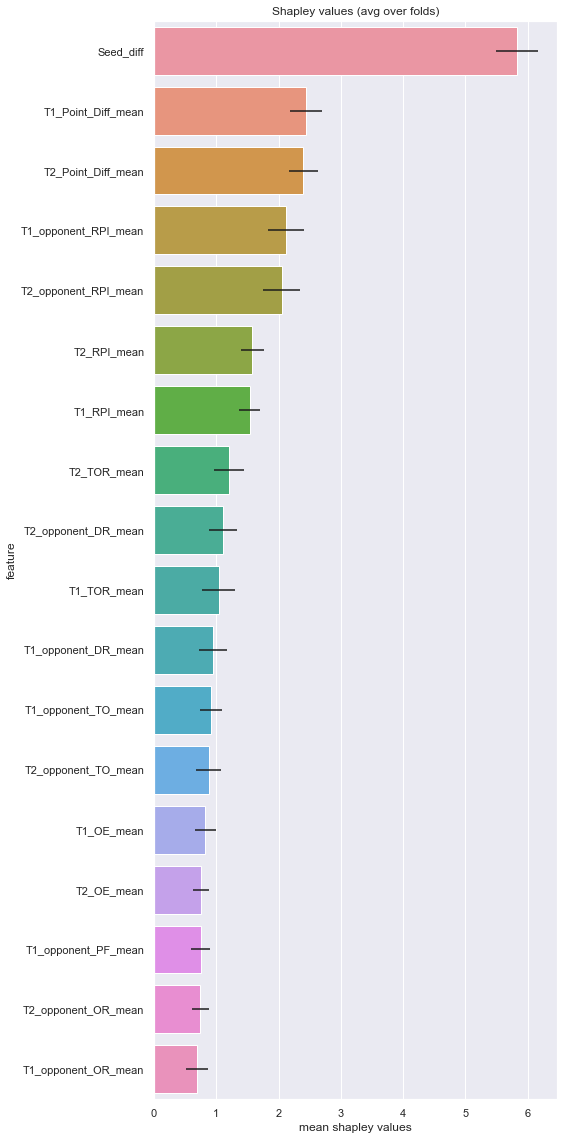

In [12]:
# Feature importance
def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(100).reset_index()
    print("len="+str(len(features))+"\n")
    print(list(best_features['feature'])[:41])
    print("\n")
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 16))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('Shapley values (avg over folds)')
    plt.tight_layout()
    plt.show()
    
display_shapley_values(feat_importance)

In [13]:
# Train a spline to convert point spreads to win probability
val_cv = []
spline_model = []
list_loss = []
for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values()), k=5))
    spline_fit = spline_model[i](oof_preds[i])    
    spline_fit = np.clip(spline_fit,0.214,0.786)

    if(GENDER_CODE == 'W'):
        spline_fit[(tourney_data.T1_seed>=6) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed>=6) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed>=10) & (tourney_data.T2_seed==8) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==8) & (tourney_data.T2_seed>=10) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed>=11) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed>=11) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed>=12) & (tourney_data.T2_seed.isin([3,6,7])) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed.isin([3,6,7])) & (tourney_data.T2_seed>=12) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed>=13) & (tourney_data.T2_seed==5) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==5) & (tourney_data.T2_seed>=13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed>=14) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed>=14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed>=5) & (tourney_data.T2_seed==1) & (tourney_data.Season!=2013) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed>=5) & (tourney_data.Season!=2013) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0

    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    adj_loss = log_loss(np.where(y>0,1,0),spline_fit)
    list_loss.append(adj_loss)
print(f"average logloss: {np.mean(list_loss)}") 
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

average logloss: 0.39544561157891245


season
2010    0.410968
2011    0.382832
2012    0.351486
2013    0.413335
2014    0.403409
2015    0.352665
2016    0.453101
2017    0.401920
2018    0.412749
2019    0.386513
2021    0.380924
dtype: float64

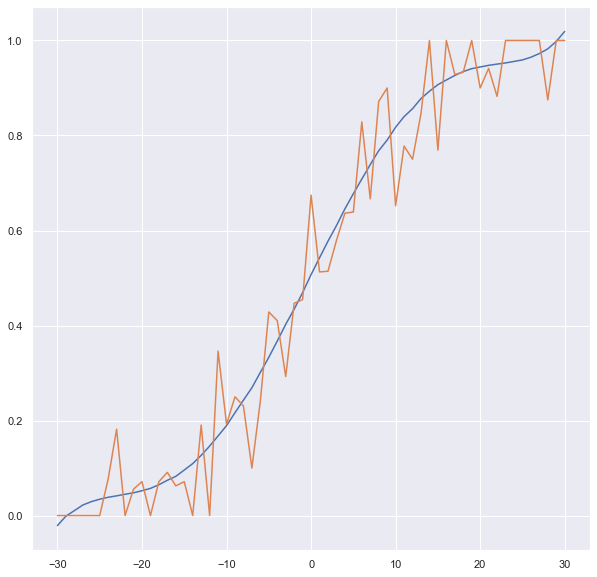

In [14]:
# Spline fit plot
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = round(plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [15]:
# Train on entire data with XGBoost
xgb_cv = []
for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          folds = KFold(n_splits = n_splits, shuffle = True, random_state = i),
          obj = cauchyobj,
          num_boost_round = 3000,
          early_stopping_rounds = 25,
        )
    )    
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
print("Average: "+str(np.mean(iteration_counts))+" rounds")

sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")

    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = iteration_counts[i],
          obj = cauchyobj,
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Average: 266.2 rounds
Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


# Prediction

In [16]:
# Merge regular season and seeds to submission
sub = pd.read_csv(STAGE_DIR + GENDER_CODE + 'SampleSubmissionStage2.csv')

sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how='left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how='left')
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how='left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how='left')
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

In [17]:
# Predict point spreads and then win probability
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)
sub_preds = []

for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.214,0.786))
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

# Override games - GO BIG or GO HOME!
if(GENDER_CODE == 'W'):
    sub.loc[(sub.T1_seed>=10) & (sub.T2_seed==8), 'Pred'] = 0.0
    sub.loc[(sub.T1_seed==8) & (sub.T2_seed>=10), 'Pred'] = 1.0
    sub.loc[(sub.T1_seed>=11) & (sub.T2_seed==2), 'Pred'] = 0.0
    sub.loc[(sub.T1_seed==2) & (sub.T2_seed>=11), 'Pred'] = 1.0
    sub.loc[(sub.T1_seed>=12) & (sub.T2_seed.isin([3,6,7])), 'Pred'] = 0.0
    sub.loc[(sub.T1_seed.isin([3,6,7])) & (sub.T2_seed>=12), 'Pred'] = 1.0
    sub.loc[(sub.T1_seed>=13) & (sub.T2_seed==5), 'Pred'] = 0.0
    sub.loc[(sub.T1_seed==5) & (sub.T2_seed>=13), 'Pred'] = 1.0
    sub.loc[(sub.T1_seed>=14) & (sub.T2_seed==4), 'Pred'] = 0.0
    sub.loc[(sub.T1_seed==4) & (sub.T2_seed>=14), 'Pred'] = 1.0   
    sub.loc[(sub.T1_seed>=5) & (sub.T2_seed==1), 'Pred'] = 0.0
    sub.loc[(sub.T1_seed==1) & (sub.T2_seed>=5), 'Pred'] = 1.0
    
sub[['ID','Pred']].to_csv(GENDER_CODE+str(COMP_YEAR)+"-R0.csv", index = None, header=['ID','Pred'])